In [1]:
import gluonts
gluonts.__version__

'0.4.2'

In [2]:
import mxnet
mxnet.__version__

'1.4.1'

In [3]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [4]:
dataname = "m4_monthly_industry"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 

In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 8370.,  8430.,  7880.,  8160.,  8290.,  8000.,  8240.,  7840.,
         8040.,  7930.,  7500.,  6610.,  7210.,  7390.,  6840.,  6600.,
         6810.,  6580.,  6040.,  6450.,  6670.,  6210.,  6330.,  6100.,
         6700.,  6690.,  5650.,  5270.,  5170.,  5870.,  6230.,  6730.,
         7370.,  7500.,  7670.,  6450.,  7140.,  6690.,  6650.,  7240.,
         7630.,  7310.,  7410.,  7720.,  7310.,  7030.,  6250.,  6430.,
         7100.,  6650.,  6200.,  6550.,  6750.,  6570.,  6540.,  6540.,
         6930.,  7340.,  7210.,  7190.,  7040.,  7460.,  8080.,  8910.,
         9330.,  9220.,  9280.,  9090.,  8990.,  8930.,  9110.,  9420.,
        10010.,  9740., 10100.,  9610.,  9810.,  9550.,  9660.,  9910.,
        10090.,  9630.,  9570.,  9290.,  9600.,  9370.,  9370.,  9460.,
         9180.,  9650.,  9400.,  9240.,  9210.,  8840.,  9090.,  9390.,
         9560.,  9590.,  9510.,  9620.,  9480.,  9930.,  9770.,  9490.,


## Plot Series

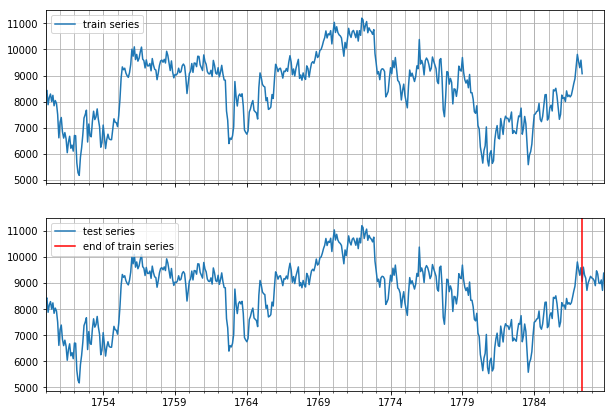

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [9]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [10]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


## Results

## `m4_hourly`

In [15]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_daily


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/test/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.95it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[0] Elapsed time 3.589 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.901361
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.42it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[1] Elapsed time 4.384 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.585315
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.49it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[2] Elapsed time 4.355 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.568182
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.56it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 4.738 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.409122
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.18it/s, avg_epoch_loss=6

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.28it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[37] Elapsed time 4.082 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.824337
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.52it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[38] Elapsed time 4.342 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.788866
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.12it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[39] Elapsed time 4.503 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.799773
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.76it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[40] Elapsed time 4.258 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.719032
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.43it/s, avg_epoch_loss=5.86]
INFO:root:Epo

100%|██████████| 50/50 [00:04<00:00, 11.17it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[74] Elapsed time 4.482 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.473138
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 13.09it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[75] Elapsed time 3.828 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.653139
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.64it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[76] Elapsed time 4.299 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.592372
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.02it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[77] Elapsed time 4.165 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.452947
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.99it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[78] Elapsed time 4.173 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.044073  0.036316  55.392045            0.035296            0.019108   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.32it/s, avg_epoch_loss=9.2]
INFO:root:Epoch[0] Elapsed time 3.495 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.199301
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.32it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[1] Elapsed time 4.422 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.807131
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.55it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[2] Elapsed time 3.990 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.701059
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.52it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[3] Elapsed time 4.348 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.381333
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.72it/s, avg_epoch_loss=6.55]
INFO:

100%|██████████| 50/50 [00:04<00:00, 12.32it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[37] Elapsed time 4.068 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.776927
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.72it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[38] Elapsed time 3.937 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.792285
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.58it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[39] Elapsed time 3.985 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.798927
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.88it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[40] Elapsed time 4.215 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.687612
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.91it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[41] Elapsed time 4.202 seconds
INFO:root

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.491678
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.51it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[75] Elapsed time 3.227 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.645621
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 13.94it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[76] Elapsed time 3.596 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.556623
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 13.84it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[77] Elapsed time 3.616 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.424150
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.66it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[78] Elapsed time 3.412 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.659473
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.511134  0.033139  45.626943            0.029062            0.014591   

   seed  epochs  num_batches  
0    43     100           50  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.19it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[0] Elapsed time 3.528 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.958504
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.72it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 4.271 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.540431
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.98it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 4.176 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.532569
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.01it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 3.850 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.356580
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.10it/s, avg_epoch_loss=6.48]
INF

100%|██████████| 50/50 [00:04<00:00, 11.96it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[37] Elapsed time 4.187 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.769165
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.42it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[38] Elapsed time 4.032 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.647235
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[39] Elapsed time 4.239 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.791014
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.92it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[40] Elapsed time 5.045 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.733501
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.67it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[41] Elapsed time 4.287 seconds
INFO:root

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.640541
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.12it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[75] Elapsed time 3.820 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.532214
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.73it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[76] Elapsed time 4.271 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.597468
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.17it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[77] Elapsed time 4.118 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.527484
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.06it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[78] Elapsed time 4.156 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.615934
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.335039  0.039457  59.033506            0.031707            0.014399   

   seed  epochs  num_batches  
0    44     100           50  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.80it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 3.382 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.855871
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.77it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1] Elapsed time 4.253 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.696991
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.90it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[2] Elapsed time 4.207 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.543584
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.23it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 4.095 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.387498
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.45it/s, avg_epoch_loss=6.5]
INFO:

100%|██████████| 50/50 [00:04<00:00, 12.11it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 4.138 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.859673
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.10it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[38] Elapsed time 4.138 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.045574
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.74it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[39] Elapsed time 3.928 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.021911
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.01it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[40] Elapsed time 4.168 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.753591
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.00it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[41] Elapsed time 4.176 seconds
INFO:roo

100%|██████████| 50/50 [00:04<00:00, 12.48it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[74] Elapsed time 4.012 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.710104
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.24it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[75] Elapsed time 4.090 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.778666
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.65it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[76] Elapsed time 3.958 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.801557
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.56it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[77] Elapsed time 3.988 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.627590
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.92it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 3.880 seconds
INFO:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.287056  0.031518  48.214068            0.027202            0.014264   

   seed  epochs  num_batches  
0    45     100           50  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.54it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 3.445 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.256379
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.72it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[1] Elapsed time 3.940 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.579045
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.67it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[2] Elapsed time 3.952 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.656089
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.92it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 3.878 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.495539
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.29it/s, avg_epoch_loss=6.53]
INFO

100%|██████████| 50/50 [00:04<00:00, 12.24it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[37] Elapsed time 4.092 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.803363
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.06it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[38] Elapsed time 4.157 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.703169
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.12it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[39] Elapsed time 3.814 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.893969
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.19it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[40] Elapsed time 4.109 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.671384
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.03it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[41] Elapsed time 4.162 seconds
INFO:root:

100%|██████████| 50/50 [00:03<00:00, 12.57it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[74] Elapsed time 3.985 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.578180
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.22it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[75] Elapsed time 4.098 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.508535
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.08it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[76] Elapsed time 4.144 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.586020
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.51it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[77] Elapsed time 4.004 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.486478
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.74it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[78] Elapsed time 3.926 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.788578  0.042815  67.646263            0.035841            0.015326   

   seed  epochs  num_batches  
0    46     100           50  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.67it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 3.412 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.482556
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.50it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1] Elapsed time 4.005 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.662988
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.69it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[2] Elapsed time 4.280 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.713157
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.98it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[3] Elapsed time 5.014 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.426951
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.12it/s, avg_epoch_loss=6.53]
INF

100%|██████████| 50/50 [00:03<00:00, 13.32it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 3.758 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.859817
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.90it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[38] Elapsed time 4.209 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.987500
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.28it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[39] Elapsed time 4.080 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.822463
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.46it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[40] Elapsed time 4.015 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.681477
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.86it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[41] Elapsed time 4.218 seconds
INFO:roo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.558763
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.27it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[75] Elapsed time 4.083 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.678489
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.54it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[76] Elapsed time 3.990 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.658451
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.71it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[77] Elapsed time 3.941 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.535416
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.98it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[78] Elapsed time 3.873 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.664820
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.832182  0.042228  72.282103             0.03782            0.021979   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.78it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[0] Elapsed time 3.386 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.728900
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.17it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1] Elapsed time 4.114 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.646514
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.14it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[2] Elapsed time 4.122 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.664266
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.91it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[3] Elapsed time 3.879 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.439060
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.50it/s, avg_epoch_loss=6.58]
INF

100%|██████████| 50/50 [00:04<00:00, 11.45it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[37] Elapsed time 4.371 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.846286
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.15it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[38] Elapsed time 3.812 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.896182
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.59it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[39] Elapsed time 4.321 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.914883
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.56it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[40] Elapsed time 3.987 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.725922
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.28it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[41] Elapsed time 4.077 seconds
INFO:root

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.701860
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.37it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[75] Elapsed time 3.259 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.676910
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.39it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[76] Elapsed time 3.485 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.768252
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.27it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[77] Elapsed time 3.505 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.702454
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.99it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[78] Elapsed time 3.579 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.739864
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.484924  0.033426  49.422879            0.028598            0.015918   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 15.36it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[0] Elapsed time 3.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.685750
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.15it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1] Elapsed time 4.118 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.514431
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.99it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[2] Elapsed time 4.172 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.607941
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.28it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 4.079 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.391629
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.24it/s, avg_epoch_loss=6.51]
INF

100%|██████████| 50/50 [00:03<00:00, 13.16it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[37] Elapsed time 3.806 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.824426
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.06it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[38] Elapsed time 4.163 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.792878
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.75it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[39] Elapsed time 3.928 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.841989
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.66it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[40] Elapsed time 3.958 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.657483
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.34it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[41] Elapsed time 4.055 seconds
INFO:roo

100%|██████████| 50/50 [00:04<00:00, 12.10it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[74] Elapsed time 4.138 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.519947
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.48it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[75] Elapsed time 4.016 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.577956
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.64it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[76] Elapsed time 3.960 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.582866
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.92it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[77] Elapsed time 4.201 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.516995
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.76it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[78] Elapsed time 4.649 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.149385  0.038236  51.391386            0.035395            0.017005   

   seed  epochs  num_batches  
0    49     100           50  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.50it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 3.454 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.191475
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.82it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[1] Elapsed time 4.232 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.611175
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.10it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 4.137 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.718332
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.32it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 4.065 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.447872
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.64it/s, avg_epoch_loss=6.56]
INF

100%|██████████| 50/50 [00:04<00:00, 12.50it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 4.007 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.869150
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.76it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[38] Elapsed time 4.254 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.010067
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.28it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[39] Elapsed time 4.078 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.918789
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.33it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[40] Elapsed time 4.060 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.706184
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.67it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[41] Elapsed time 3.953 seconds
INFO:roo

100%|██████████| 50/50 [00:04<00:00, 11.68it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[74] Elapsed time 4.290 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.639934
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.99it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[75] Elapsed time 3.854 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.654625
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.58it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 3.980 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.753828
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.27it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 4.078 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.592999
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.12it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[78] Elapsed time 4.126 seconds
INFO

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.16608  0.038273  55.503485            0.034912             0.01826    50   

   epochs  num_batches  
0     100           50  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245073
100%|██████████| 50/50 [00:03<00:00, 14.48it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[0] Elapsed time 3.457 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.495141
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.16it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[1] Elapsed time 3.805 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.569876
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.59it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[2] Elapsed time 4.318 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.545971
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.17it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[3] Elapsed time 4.117 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.351771
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.85it/s, avg_epoch_loss=6.49]
INFO

100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[37] Elapsed time 4.237 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.734659
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.61it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[38] Elapsed time 3.969 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.930589
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.55it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[39] Elapsed time 3.992 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.839431
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.34it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[40] Elapsed time 4.414 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.839012
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.15it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[41] Elapsed time 4.125 seconds
INFO:roo

100%|██████████| 50/50 [00:04<00:00, 11.90it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[74] Elapsed time 4.209 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.689944
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.89it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[75] Elapsed time 4.217 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.664920
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.72it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 4.273 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.700493
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.61it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[77] Elapsed time 3.967 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.620291
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.72it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[78] Elapsed time 3.937 seconds
INFO:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.625253  0.033499  53.384372            0.029808            0.015006   

   seed  epochs  num_batches  
0    51     100           50  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,4.044073,0.036316,55.392045,0.035296,0.019108,42,100,50
0,3.511134,0.033139,45.626943,0.029062,0.014591,43,100,50
0,4.335039,0.039457,59.033506,0.031707,0.014399,44,100,50
0,3.287056,0.031518,48.214068,0.027202,0.014264,45,100,50
0,4.788578,0.042815,67.646263,0.035841,0.015326,46,100,50
0,4.832182,0.042228,72.282103,0.037820,0.021979,47,100,50
0,3.484924,0.033426,49.422879,0.028598,0.015918,48,100,50
0,4.149385,0.038236,51.391386,0.035395,0.017005,49,100,50
0,4.166080,0.038273,55.503485,0.034912,0.018260,50,100,50
0,3.625253,0.033499,53.384372,0.029808,0.015006,51,100,50
